In [25]:
import pandas as pd
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
from shapely.geometry import LineString
import matplotlib as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt2
import rasterio as rio
import numpy as np
from scipy import stats
import requests
from io import BytesIO
from zipfile import ZipFile
from functools import partial
import pygeohash as gh

In [26]:
url = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv'
NYC_AQ = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson'
NYC_geojson = gpd.read_file(url)


In [27]:
NYC_AQ

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,0,0,0,23.7,57.3,4.508813
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,0,0,0,23.7,57.8,5.462420
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,0,0,0,0,0,0,0,23.7,57.8,5.154881
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,0,0,0,0,0,0,0,23.6,57.6,4.508813
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,0,0,0,0,0,0,0,23.6,57.5,5.539503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169994,NYCP2_CS03A,1631457109,40.823353,-73.890488,115,11,2,0,1,0,...,0,0,0,0,0,0,0,24.6,54.8,5.460360
169995,NYCP2_CS03A,1631457114,40.823349,-73.890480,132,8,2,0,0,0,...,0,0,0,0,0,0,0,24.6,54.8,5.298209
169996,NYCP2_CS03A,1631457119,40.823349,-73.890480,147,14,0,0,0,0,...,0,0,0,0,0,0,0,24.6,54.8,6.470661
169997,NYCP2_CS03A,1631457124,40.823345,-73.890488,121,8,2,0,1,1,...,0,0,0,0,0,0,0,24.6,54.6,6.424142


In [28]:
print(NYC_geojson.head())

      neighborhood boroughCode        borough  \
0         Allerton           2          Bronx   
1  Alley Pond Park           4         Queens   
2    Arden Heights           5  Staten Island   
3        Arlington           5  Staten Island   
4         Arrochar           5  Staten Island   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/Neighborho...   
1  http://nyc.pediacities.com/Resource/Neighborho...   
2  http://nyc.pediacities.com/Resource/Neighborho...   
3  http://nyc.pediacities.com/Resource/Neighborho...   
4  http://nyc.pediacities.com/Resource/Neighborho...   

                                            geometry  
0  POLYGON ((-73.84860 40.87167, -73.84582 40.870...  
1  POLYGON ((-73.74333 40.73888, -73.74371 40.739...  
2  POLYGON ((-74.16983 40.56108, -74.16982 40.561...  
3  POLYGON ((-74.15975 40.64142, -74.15998 40.641...  
4  POLYGON ((-74.06078 40.59319, -74.06079 40.593...  


In [29]:
columns_to_keep = ['latitude', 'longitude', 'pm25']
NYC_AQ = NYC_AQ[columns_to_keep]

NYC_AQ = NYC_AQ[(NYC_AQ['latitude'] != 0) & (NYC_AQ['longitude'] != 0)]

NYC_AQ['longitude'] = pd.to_numeric(NYC_AQ['longitude'])
NYC_AQ['latitude'] = pd.to_numeric(NYC_AQ['latitude'])

print(NYC_AQ)

         latitude  longitude      pm25
0       40.847672 -73.869316  4.508813
1       40.847668 -73.869316  5.462420
2       40.847649 -73.869362  5.154881
3       40.847649 -73.869362  4.508813
4       40.847649 -73.869362  5.539503
...           ...        ...       ...
169994  40.823353 -73.890488  5.460360
169995  40.823349 -73.890480  5.298209
169996  40.823349 -73.890480  6.470661
169997  40.823345 -73.890488  6.424142
169998  40.823338 -73.890488  6.526187

[169999 rows x 3 columns]


In [30]:
geohash_precision = 7
NYC_AQ['geohash']=NYC_AQ.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=geohash_precision), axis=1)
NYC_AQ.head()

,latitude,longitude,pm25,geohash
0,40.847672,-73.869316,4.508813,dr72rh4
1,40.847668,-73.869316,5.462420,dr72rh4
2,40.847649,-73.869362,5.154881,dr72rh1
3,40.847649,-73.869362,4.508813,dr72rh1
4,40.847649,-73.869362,5.539503,dr72rh1


In [31]:
NYC_AQ = gpd.GeoDataFrame(NYC_AQ)
NYC_AQ.head()

,latitude,longitude,pm25,geohash
0,40.847672,-73.869316,4.508813,dr72rh4
1,40.847668,-73.869316,5.462420,dr72rh4
2,40.847649,-73.869362,5.154881,dr72rh1
3,40.847649,-73.869362,4.508813,dr72rh1
4,40.847649,-73.869362,5.539503,dr72rh1


In [32]:
NYC_AQ = gpd.GeoDataFrame(NYC_AQ, geometry = gpd.points_from_xy(x=NYC_AQ['longitude'], y=NYC_AQ['latitude']))
NYC_AQ = NYC_AQ.set_crs('EPSG:4326')

NYC_AQ_geojson = gpd.sjoin(NYC_AQ, NYC_geojson, predicate="within")
NYC_AQ_geojson.head()

,latitude,longitude,pm25,geohash,geometry,index_right,neighborhood,boroughCode,borough,@id
0,40.847672,-73.869316,4.508813,dr72rh4,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
1,40.847668,-73.869316,5.462420,dr72rh4,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
2,40.847649,-73.869362,5.154881,dr72rh1,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
3,40.847649,-73.869362,4.508813,dr72rh1,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
4,40.847649,-73.869362,5.539503,dr72rh1,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...


In [33]:
# prompt: display all unique pm25 values in the last column of AQ_points
unique_pm25_values = NYC_AQ_geojson['pm25'].unique()
print(unique_pm25_values)

[4.50881326 5.46242028 5.15488086 ... 9.68400335 7.86017365 3.11785864]


In [34]:
# prompt: display the total value count of pm25
pm25_value_counts = NYC_AQ_geojson['pm25'].value_counts()
print(pm25_value_counts)

pm25
4.348238    6000
2.274121    2018
2.199988    1767
2.220632    1233
4.311103    1078
            ... 
5.635506       1
3.996444       1
5.608798       1
3.566272       1
3.117859       1
Name: count, Length: 35045, dtype: int64


In [35]:
max_value = NYC_AQ_geojson['pm25'].max()
min_value = NYC_AQ_geojson['pm25'].min()
print(max_value)
min_value


12.74441924


1.568473024

In [36]:
NYC_AQ_geojson = NYC_AQ_geojson.to_crs('EPSG:32618')

In [37]:
AQ_NYC_raster = make_geocube(
        vector_data = NYC_AQ_geojson,
        measurements = ['pm25'],
        resolution = (-5, 5),
        rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add),
        fill = 0,
        output_crs="EPSG:32618")

In [38]:
AQ_NYC_raster["pm25"].rio.to_raster(r'./output_samples/AQ_NYC_raster_overlayed_pm25.tiff')

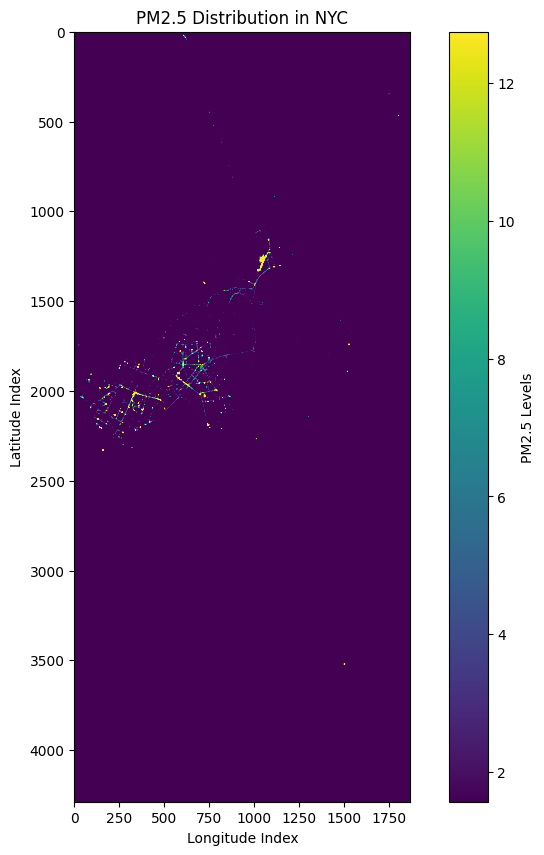

In [42]:
# Load the raster file
with rio.open("./output_samples/AQ_NYC_raster_overlayed_pm25.tiff") as src:
    data = src.read(1)  # read the first band

# Set up the figure
plt2.figure(figsize=(10, 10))

# Display the raster data with a colormap
plt2.imshow(data, cmap='viridis', vmin=1.568473024, vmax=12.74441924)  # set the range of the colormap
plt2.colorbar(label='PM2.5 Levels')  # add a color bar

# Add titles and labels if necessary
plt2.title('PM2.5 Distribution in NYC')
plt2.xlabel('Longitude Index')
plt2.ylabel('Latitude Index')

# Show the plot
plt2.show()

In [44]:
landsat = rio.open("./output_samples/AQ_NYC_raster_overlayed_pm25.tiff")

In [45]:
# The CRS
landsat.crs

CRS.from_epsg(32618)

In [46]:
# The bounds
landsat.bounds

BoundingBox(left=589990.0, bottom=4507295.0, right=599345.0, top=4528735.0)

In [47]:
# The number of bands available
landsat.count

1

In [48]:
# The band numbers that are available
landsat.indexes

(1,)

In [49]:
# Number of pixels in the x and y directions
landsat.shape

(4288, 1871)

In [50]:
# The 6 parameters that map from pixel to real space
landsat.transform

Affine(5.0, 0.0, 589990.0,
       0.0, -5.0, 4528735.0)